In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time 
import random
from qulacs import Observable
from qulacs import QuantumState
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix
from utility import show_observable
from scipy.linalg import expm

# ハミルトニアンダイナミクスをobservableからシステマティックに構成する
- add_observable_rotationはバグっぽい？
- numpyで計算したユニタリ演算とqulacsでobservableからシステマティックにTrotter展開した回路で同じになるか検証する

まずは、1量子ビットのハミルトニアンが $H=Y$ よういう簡単な例で、

In [2]:
from qulacs.state import inner_product
from qulacs import ParametricQuantumCircuit

nqubit = 1
state =QuantumState(nqubit)

#初期状態は特殊な状態を避けたいのでランダム状態にする
state.set_Haar_random_state()

copied_state = state.copy()

#qulacsを使った計算
dt = 0.01
T = np.pi*random.random()
rep = int(T/dt)

#observableを定義する
hamiltonian = Observable(nqubit)
hamiltonian.add_operator(1.0,"Y 0")
show_observable(hamiltonian)
term = hamiltonian.get_term(0)


circuit = ParametricQuantumCircuit(nqubit)
circuit.add_parametric_multi_Pauli_rotation_gate(term.get_index_list(),term.get_pauli_id_list(), -2.0*T)
circuit.update_quantum_state(state)
#print(state)

#numpy 経由の計算
pY = np.array([[0+0.0j,-1.0j],[0.0+1.0j,0.0+0.0j]])
unitary = expm(-1.j*T*pY)
qulacs_unitary = DenseMatrix(0,unitary)
qulacs_unitary.update_quantum_state(copied_state)
#print(copied_state)

#print("a", abs(inner_product(state,tmp)))
#print("b",abs(inner_product(state,copied_state)))
print("c",abs(inner_product(state,copied_state))**2)


(1+0j) Y0
c 1.0


内積が1になっている事がわかったので、numpyで計算した$e^{-iHt}$とqulacsのPauli rotationで作ったユニタリ演算が一致していることがわかる。ただし、1体のパウリしか登場したないのでTrotter展開はしなかった。次にハミルトニアンが、$H=X+Z$の場合を考えTrotter展開をしてみる。

In [3]:
from qulacs.state import inner_product
from qulacs import ParametricQuantumCircuit

nqubit = 1
state =QuantumState(nqubit)

#初期状態は特殊な状態を避けたいのでランダム状態にする
state.set_Haar_random_state()

copied_state = state.copy()

#qulacsを使った計算
dt = 0.01
T = np.pi*random.random()
rep = int(T/dt)

#observableを定義する
hamiltonian = Observable(nqubit)
hamiltonian.add_operator(1.0,"X 0")
hamiltonian.add_operator(1.0,"Z 0")
show_observable(hamiltonian)
term = hamiltonian.get_term(0)


circuit = ParametricQuantumCircuit(nqubit)

#Trotter展開をする必要があるのでdtの時間発展をrep回繰り返すことになる
for _ in range(rep):
    for i in range(hamiltonian.get_term_count()):
        term = hamiltonian.get_term(i)
        circuit.add_parametric_multi_Pauli_rotation_gate(term.get_index_list(),term.get_pauli_id_list(), -2.0*dt)
    
circuit.update_quantum_state(state)
#print(state)

#numpy 経由の計算
pX = np.array([[0+0.0j,1+0.0j],[1+0.0j,0+0.0j]])
pZ = np.array([[1+0.0j,0+0.0j],[0+0.0j,-1+0.0j]])
num_hami = pX+pZ
unitary = expm(-1.j*T*num_hami)
qulacs_unitary = DenseMatrix(0,unitary)
qulacs_unitary.update_quantum_state(copied_state)
#print(copied_state)

#print("a", abs(inner_product(state,tmp)))
#print("b",abs(inner_product(state,copied_state)))
print("c",abs(inner_product(state,copied_state))**2)

(1+0j) X0
(1+0j) Z0
c 0.999810030285307


$dt^2$の誤差の範囲でTrotter展開とnumpyの行列指数関数が一致している。次は一般の多体ハミルトニアンに拡張しよう。まずはハミルトニアンを係数のリストからシステマティックに定義する関数を用意しておく。

In [4]:
def add_ZZ_interactions(operator,ListOfInt,ListOfJij):
    nqubits = operator.get_qubit_count()
    
    for k in range(len(ListOfInt)):
        operator.add_operator(ListOfJij[k],"Z {0}".format(ListOfInt[k][0])+"Z {0}".format(ListOfInt[k][1]))
    return operator

def add_X_fields(operator,field):
    nqubits = operator.get_qubit_count()
    for k in range(nqubits):
        operator.add_operator(field[k],"X {0}".format(k)) 
    return operator

def add_Z_fields(operator,field):
    nqubits = operator.get_qubit_count()
    for k in range(nqubits):
        operator.add_operator(field[k],"Z {0}".format(k)) 
    return operator

これを用いてランダムな結合や磁場（$\pm 1$）を持つ縦磁場・横磁場イジング模型を定義する。

In [5]:
nqubit = 2
Ising_hamiltonian = Observable(nqubit)

ListOfInt = [[i,j] for i in range(nqubit) for j in range(i)]
ListOfJij = np.array([(-1)**random.randint(0,1) for i in range(len(ListOfInt))])
hz = np.array([(-1)**random.randint(0,1) for i in range(nqubit)])
hx = np.array([(-1)**random.randint(0,1) for i in range(nqubit)])

print(ListOfJij)
print(hz)
print(hx)

Ising_hamiltonian = add_ZZ_interactions(Ising_hamiltonian,ListOfInt,ListOfJij)
Ising_hamiltonian = add_Z_fields(Ising_hamiltonian,hz)
Ising_hamiltonian = add_X_fields(Ising_hamiltonian,hx)
show_observable(Ising_hamiltonian)

[-1]
[-1  1]
[ 1 -1]
(-1+0j) Z1 Z0
(-1+0j) Z0
(1+0j) Z1
(1+0j) X0
(-1+0j) X1


observableから$dt$を与えるとTrotterized circuitを返す関数を作っておく。

In [6]:
def add_Trotterized_gates_from_observable(parametric_circuit,hamiltonian,dt):

    nqubits = hamiltonian.get_qubit_count()

    for j in range(hamiltonian.get_term_count()):
        pauli = hamiltonian.get_term(j)

        # Get the subscript of each pauli symbol
        index_list = pauli.get_index_list()

        # Get pauli symbols (I,X,Y,Z -> 0,1,2,3)
        pauli_id_list = pauli.get_pauli_id_list()
        
        #Get coefficient
        coeff = pauli.get_coef()

        #qulacsのPauli rotaitonは2倍されていることに注意（回転方向も注意）
        parametric_circuit.add_parametric_multi_Pauli_rotation_gate(index_list, pauli_id_list,-2.0*coeff.real*dt)
    return parametric_circuit

Trotterized circuitを作る。

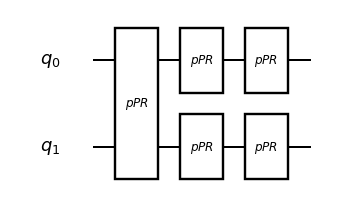

In [7]:
circuit = ParametricQuantumCircuit(nqubit)
circuit = add_Trotterized_gates_from_observable(circuit,Ising_hamiltonian,dt)

from qulacsvis import circuit_drawer
circuit_drawer(circuit, "mpl")

numpyでテンソル積空間に作用する演算子を定義する

In [8]:
import numpy as np
#パウリ演算子
pI = np.array([[1+0.0j,0+0.0j],[0+0.0j,1+0.0j]])
pX = np.array([[0+0.0j,1+0.0j],[1+0.0j,0+0.0j]])
pZ = np.array([[1+0.0j,0+0.0j],[0+0.0j,-1+0.0j]])
pY = np.array([[0+0.0j,-1.0j],[0.0+1.0j,0.0+0.0j]])
#pHad = (pX+pZ)/np.sqrt(2)
#pP0 = (pI+pZ)/2
#pP1 = (pI-pZ)/2

def define_OneQubitGate(nqubits):    
    global nX,nY,nZ,nH,nP0,nP1,nIde
    nX=[1]*(nqubits)
#    nY=[1]*(nqubits)
    nZ=[1]*(nqubits)
#    nH=[1]*(nqubits)
#    nP0=[1]*(nqubits)
#    nP1=[1]*(nqubits)

    for k in range(nqubits):
        for j in range(nqubits):
            i = nqubits - 1 - k # oder of tensor product
            if(k!= j):

                
                nX[i] = np.kron(pI,nX[i])
#                nY[i] = np.kron(pI,nY[i])
                nZ[i] = np.kron(pI,nZ[i])
#                nH[i] = np.kron(pI,nH[i])
#                nP0[i] = np.kron(pI,nP0[i])
#                nP1[i] = np.kron(pI,nP1[i])
            else:
                nX[i] = np.kron(pX,nX[i])
#             nY[i] = np.kron(pY,nY[i])
                nZ[i] = np.kron(pZ,nZ[i])
 #               nH[i] = np.kron(pHad,nH[i])
 #               nP0[i] = np.kron(pP0,nP0[i])
 #               nP1[i] = np.kron(pP1,nP1[i])
    nIde = np.eye(2**nqubits)

テンソル積をとる順序も含めて正しいか確認

In [9]:
define_OneQubitGate(nqubit)
nZ[0]

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j, -0.+0.j],
       [ 0.+0.j,  0.+0.j, -0.+0.j, -1.+0.j]])

numpyでイジングハミルトニアンを定義する

In [10]:
np_Ising_hami =  [[0 for i in range(2**nqubit)] for i in range(2**nqubit)]

#イジング相互作用
for i in range(len(ListOfInt)):
    np_Ising_hami =  np_Ising_hami + ListOfJij[i]*np.dot(nZ[ListOfInt[i][0]],nZ[ListOfInt[i][1]])
    
#縦磁場と横磁場
for i in range(nqubit):
    np_Ising_hami =  np_Ising_hami +hz[i]*nZ[i]
for i in range(nqubit):
    np_Ising_hami =  np_Ising_hami +hx[i]*nX[i]

print(np_Ising_hami)

[[-1.+0.j -1.+0.j  1.+0.j  0.+0.j]
 [-1.+0.j -1.+0.j  0.+0.j  1.+0.j]
 [ 1.+0.j  0.+0.j  3.+0.j -1.+0.j]
 [ 0.+0.j  1.+0.j -1.+0.j -1.+0.j]]


numpyとqulacsで比較する。

In [11]:
state =QuantumState(nqubit)

#初期状態は特殊な状態を避けたいのでランダム状態にする
state.set_Haar_random_state()

copied_state = state.copy()

#qulacsを使った計算
dt = 0.01
T = np.pi*random.random()
rep = int(T/dt)


circuit = ParametricQuantumCircuit(nqubit)

#Trotter展開をする必要があるのでdtの時間発展をrep回繰り返すことになる
for _ in range(rep):
    circuit =  add_Trotterized_gates_from_observable(circuit,Ising_hamiltonian,dt)
    
circuit.update_quantum_state(state)
#print(state)

#numpy 経由の計算
unitary = expm(-1.j*T*np_Ising_hami)
qulacs_unitary = DenseMatrix([nqubit -1 - i for i in range(nqubit)],unitary)
qulacs_unitary.update_quantum_state(copied_state)
#print(copied_state)

print(abs(inner_product(state,copied_state))**2)

0.999819513782398


うまく言っているようなので5量子ビットくらいでテストしてみる

In [12]:
nqubit = 5
Ising_hamiltonian = Observable(nqubit)

#ハミルトニアンの係数の設定
ListOfInt = [[i,j] for i in range(nqubit) for j in range(i)]
ListOfJij = np.array([(-1)**random.randint(0,1) for i in range(len(ListOfInt))])
hz = np.array([(-1)**random.randint(0,1) for i in range(nqubit)])
hx = np.array([(-1)**random.randint(0,1) for i in range(nqubit)])

#print(ListOfJij)
#print(hz)
#print(hx)

#qulacsでのハミルトニアンの定義
Ising_hamiltonian = add_ZZ_interactions(Ising_hamiltonian,ListOfInt,ListOfJij)
Ising_hamiltonian = add_Z_fields(Ising_hamiltonian,hz)
Ising_hamiltonian = add_X_fields(Ising_hamiltonian,hx)
show_observable(Ising_hamiltonian)

#numpy でのハミルトニアンの定義
define_OneQubitGate(nqubit)
np_Ising_hami =  [[0 for i in range(2**nqubit)] for i in range(2**nqubit)]

#イジング相互作用
for i in range(len(ListOfInt)):
    np_Ising_hami =  np_Ising_hami + ListOfJij[i]*np.dot(nZ[ListOfInt[i][0]],nZ[ListOfInt[i][1]])
    
#縦磁場と横磁場
for i in range(nqubit):
    np_Ising_hami =  np_Ising_hami +hz[i]*nZ[i]
for i in range(nqubit):
    np_Ising_hami =  np_Ising_hami +hx[i]*nX[i]

state =QuantumState(nqubit)

#初期状態は特殊な状態を避けたいのでランダム状態にする
state.set_Haar_random_state()

copied_state = state.copy()

#qulacsを使った計算
dt = 0.01
T = np.pi*random.random()
rep = int(T/dt)

circuit = ParametricQuantumCircuit(nqubit)

#Trotter展開をする必要があるのでdtの時間発展をrep回繰り返すことになる
for _ in range(rep):
    circuit =  add_Trotterized_gates_from_observable(circuit,Ising_hamiltonian,dt)

st_time = time.time()
circuit.update_quantum_state(state)
#print(state)
print("qulacs",time.time()-st_time)

#numpy 経由の計算
st_time = time.time()

unitary = expm(-1.j*T*np_Ising_hami)
qulacs_unitary = DenseMatrix([nqubit -1 - i for i in range(nqubit)],unitary)
qulacs_unitary.update_quantum_state(copied_state)
#print(copied_state)

print("numpy",time.time()-st_time)

print(abs(inner_product(state,copied_state))**2)

(1+0j) Z1 Z0
(1+0j) Z2 Z0
(-1+0j) Z2 Z1
(-1+0j) Z3 Z0
(-1+0j) Z3 Z1
(1+0j) Z3 Z2
(1+0j) Z4 Z0
(1+0j) Z4 Z1
(1+0j) Z4 Z2
(-1+0j) Z4 Z3
(1+0j) Z0
(1+0j) Z1
(1+0j) Z2
(1+0j) Z3
(1+0j) Z4
(-1+0j) X0
(1+0j) X1
(1+0j) X2
(-1+0j) X3
(-1+0j) X4
qulacs 0.005180835723876953
numpy 0.0030858516693115234
0.9998439401932244


5quibtくらいだと numpyで行列の指数関数計算したのとあまり計算時間はかわらない。

In [62]:
nqubit = 10
Ising_hamiltonian = Observable(nqubit)

#ハミルトニアンの係数の設定
ListOfInt = [[i,j] for i in range(nqubit) for j in range(i)]
ListOfJij = np.array([(-1)**random.randint(0,1) for i in range(len(ListOfInt))])
hz = np.array([(-1)**random.randint(0,1) for i in range(nqubit)])
hx = np.array([(-1)**random.randint(0,1) for i in range(nqubit)])

#print(ListOfJij)
#print(hz)
#print(hx)

#qulacsでのハミルトニアンの定義
Ising_hamiltonian = add_ZZ_interactions(Ising_hamiltonian,ListOfInt,ListOfJij)
Ising_hamiltonian = add_Z_fields(Ising_hamiltonian,hz)
Ising_hamiltonian = add_X_fields(Ising_hamiltonian,hx)
show_observable(Ising_hamiltonian)

#numpy でのハミルトニアンの定義
define_OneQubitGate(nqubit)
np_Ising_hami =  [[0 for i in range(2**nqubit)] for i in range(2**nqubit)]

#イジング相互作用
for i in range(len(ListOfInt)):
    np_Ising_hami =  np_Ising_hami + ListOfJij[i]*np.dot(nZ[ListOfInt[i][0]],nZ[ListOfInt[i][1]])
    
#縦磁場と横磁場
for i in range(nqubit):
    np_Ising_hami =  np_Ising_hami +hz[i]*nZ[i]
for i in range(nqubit):
    np_Ising_hami =  np_Ising_hami +hx[i]*nX[i]

state =QuantumState(nqubit)

#初期状態は特殊な状態を避けたいのでランダム状態にする
state.set_Haar_random_state()

copied_state = state.copy()

#qulacsを使った計算
dt = 0.01
T = np.pi*random.random()
rep = int(T/dt)

circuit = ParametricQuantumCircuit(nqubit)

#Trotter展開をする必要があるのでdtの時間発展をrep回繰り返すことになる
for _ in range(rep):
    circuit =  add_Trotterized_gates_from_observable(circuit,Ising_hamiltonian,dt)

st_time = time.time()
circuit.update_quantum_state(state)
#print(state)
print("qulacs",time.time()-st_time)

#numpy 経由の計算
st_time = time.time()

unitary = expm(-1.j*T*np_Ising_hami)
qulacs_unitary = DenseMatrix([nqubit -1 - i for i in range(nqubit)],unitary)
qulacs_unitary.update_quantum_state(copied_state)
#print(copied_state)

print("numpy",time.time()-st_time)

print(abs(inner_product(state,copied_state))**2)

(-1+0j) Z1 Z0
(-1+0j) Z2 Z0
(-1+0j) Z2 Z1
(-1+0j) Z3 Z0
(-1+0j) Z3 Z1
(1+0j) Z3 Z2
(1+0j) Z4 Z0
(1+0j) Z4 Z1
(1+0j) Z4 Z2
(-1+0j) Z4 Z3
(1+0j) Z5 Z0
(-1+0j) Z5 Z1
(1+0j) Z5 Z2
(1+0j) Z5 Z3
(-1+0j) Z5 Z4
(1+0j) Z6 Z0
(1+0j) Z6 Z1
(-1+0j) Z6 Z2
(-1+0j) Z6 Z3
(-1+0j) Z6 Z4
(1+0j) Z6 Z5
(1+0j) Z7 Z0
(1+0j) Z7 Z1
(-1+0j) Z7 Z2
(1+0j) Z7 Z3
(-1+0j) Z7 Z4
(-1+0j) Z7 Z5
(-1+0j) Z7 Z6
(-1+0j) Z8 Z0
(-1+0j) Z8 Z1
(-1+0j) Z8 Z2
(1+0j) Z8 Z3
(-1+0j) Z8 Z4
(1+0j) Z8 Z5
(1+0j) Z8 Z6
(1+0j) Z8 Z7
(1+0j) Z9 Z0
(1+0j) Z9 Z1
(1+0j) Z9 Z2
(1+0j) Z9 Z3
(1+0j) Z9 Z4
(-1+0j) Z9 Z5
(1+0j) Z9 Z6
(-1+0j) Z9 Z7
(1+0j) Z9 Z8
(1+0j) Z0
(-1+0j) Z1
(-1+0j) Z2
(1+0j) Z3
(1+0j) Z4
(-1+0j) Z5
(-1+0j) Z6
(1+0j) Z7
(-1+0j) Z8
(-1+0j) Z9
(1+0j) X0
(-1+0j) X1
(-1+0j) X2
(1+0j) X3
(-1+0j) X4
(1+0j) X5
(1+0j) X6
(-1+0j) X7
(-1+0j) X8
(1+0j) X9
qulacs 0.13643717765808105
numpy 1.6088216304779053
0.9963649552432076


10量子ビットになると流石にqulacsでトロッター展開の方が速そうだ。

In [13]:
nqubit = 11
Ising_hamiltonian = Observable(nqubit)

#ハミルトニアンの係数の設定
ListOfInt = [[i,j] for i in range(nqubit) for j in range(i)]
ListOfJij = np.array([(-1)**random.randint(0,1) for i in range(len(ListOfInt))])
hz = np.array([(-1)**random.randint(0,1) for i in range(nqubit)])
hx = np.array([(-1)**random.randint(0,1) for i in range(nqubit)])

#print(ListOfJij)
#print(hz)
#print(hx)

#qulacsでのハミルトニアンの定義
Ising_hamiltonian = add_ZZ_interactions(Ising_hamiltonian,ListOfInt,ListOfJij)
Ising_hamiltonian = add_Z_fields(Ising_hamiltonian,hz)
Ising_hamiltonian = add_X_fields(Ising_hamiltonian,hx)
show_observable(Ising_hamiltonian)

#numpy でのハミルトニアンの定義
define_OneQubitGate(nqubit)
np_Ising_hami =  [[0 for i in range(2**nqubit)] for i in range(2**nqubit)]

#イジング相互作用
for i in range(len(ListOfInt)):
    np_Ising_hami =  np_Ising_hami + ListOfJij[i]*np.dot(nZ[ListOfInt[i][0]],nZ[ListOfInt[i][1]])
    
#縦磁場と横磁場
for i in range(nqubit):
    np_Ising_hami =  np_Ising_hami +hz[i]*nZ[i]
for i in range(nqubit):
    np_Ising_hami =  np_Ising_hami +hx[i]*nX[i]

state =QuantumState(nqubit)

#初期状態は特殊な状態を避けたいのでランダム状態にする
state.set_Haar_random_state()

copied_state = state.copy()

#qulacsを使った計算
dt = 0.01
T = np.pi*random.random()
rep = int(T/dt)

circuit = ParametricQuantumCircuit(nqubit)

#Trotter展開をする必要があるのでdtの時間発展をrep回繰り返すことになる
for _ in range(rep):
    circuit =  add_Trotterized_gates_from_observable(circuit,Ising_hamiltonian,dt)

st_time = time.time()
circuit.update_quantum_state(state)
#print(state)
print("qulacs",time.time()-st_time)

#numpy 経由の計算
st_time = time.time()

unitary = expm(-1.j*T*np_Ising_hami)
qulacs_unitary = DenseMatrix([nqubit -1 - i for i in range(nqubit)],unitary)
qulacs_unitary.update_quantum_state(copied_state)
#print(copied_state)

print("numpy",time.time()-st_time)

print(abs(inner_product(state,copied_state))**2)

(-1+0j) Z1 Z0
(-1+0j) Z2 Z0
(1+0j) Z2 Z1
(1+0j) Z3 Z0
(-1+0j) Z3 Z1
(1+0j) Z3 Z2
(-1+0j) Z4 Z0
(1+0j) Z4 Z1
(-1+0j) Z4 Z2
(1+0j) Z4 Z3
(-1+0j) Z5 Z0
(1+0j) Z5 Z1
(-1+0j) Z5 Z2
(1+0j) Z5 Z3
(1+0j) Z5 Z4
(1+0j) Z6 Z0
(1+0j) Z6 Z1
(-1+0j) Z6 Z2
(-1+0j) Z6 Z3
(1+0j) Z6 Z4
(1+0j) Z6 Z5
(1+0j) Z7 Z0
(1+0j) Z7 Z1
(1+0j) Z7 Z2
(1+0j) Z7 Z3
(1+0j) Z7 Z4
(-1+0j) Z7 Z5
(-1+0j) Z7 Z6
(1+0j) Z8 Z0
(-1+0j) Z8 Z1
(-1+0j) Z8 Z2
(1+0j) Z8 Z3
(1+0j) Z8 Z4
(-1+0j) Z8 Z5
(-1+0j) Z8 Z6
(1+0j) Z8 Z7
(1+0j) Z9 Z0
(-1+0j) Z9 Z1
(1+0j) Z9 Z2
(-1+0j) Z9 Z3
(-1+0j) Z9 Z4
(1+0j) Z9 Z5
(1+0j) Z9 Z6
(1+0j) Z9 Z7
(-1+0j) Z9 Z8
(-1+0j) Z10 Z0
(-1+0j) Z10 Z1
(-1+0j) Z10 Z2
(-1+0j) Z10 Z3
(1+0j) Z10 Z4
(1+0j) Z10 Z5
(-1+0j) Z10 Z6
(-1+0j) Z10 Z7
(-1+0j) Z10 Z8
(1+0j) Z10 Z9
(1+0j) Z0
(1+0j) Z1
(1+0j) Z2
(1+0j) Z3
(-1+0j) Z4
(1+0j) Z5
(-1+0j) Z6
(-1+0j) Z7
(-1+0j) Z8
(1+0j) Z9
(1+0j) Z10
(1+0j) X0
(1+0j) X1
(-1+0j) X2
(-1+0j) X3
(-1+0j) X4
(1+0j) X5
(-1+0j) X6
(1+0j) X7
(1+0j) X8
(1+0j) X9
(-1+0j) X10
qulacs 0.361019849